In [102]:
import pandas as pd
import numpy as np
import scipy.stats
import os, re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [138]:
files = list(filter(
    lambda x: '.feather' in x,# and ('none' in x or 'rc_' in x or 'bigram' in x),
    os.listdir('./roberta/feathers')))

In [124]:
len(files)

24

In [139]:
data = {f: pd.read_feather('./roberta/feathers/'+f).set_index('Unnamed: 0') for f in tqdm(files) if '.feather' in f}# and ('none' in f or 'rc_' in f or 'bigram' in f)}

100%|██████████| 22/22 [00:04<00:00,  4.44it/s]


In [140]:
for f, df in tqdm(data.items()):
    df['singular_grammaticality'] = df.candidate2_base_prob / df.candidate1_base_prob
    df['plural_grammaticality']   = df.candidate1_alt1_prob / df.candidate2_alt1_prob
    df['inv_singular_grammaticality'] = 1 / df.singular_grammaticality
    df['inv_plural_grammaticality']   = 1 / df.plural_grammaticality
    df['yz'] = df.candidate2_prob / df.candidate1_prob
    df['effect'] = df.yz / df.singular_grammaticality - 1
    df['total_effect'] = 1 / (df.plural_grammaticality * df.singular_grammaticality) - 1

100%|██████████| 22/22 [00:06<00:00,  3.27it/s]


In [141]:
data_agg  = {}
data_top5 = {}
cols = [
    'neuron', 'layer', 
    'effect', 
    'singular_grammaticality', 'plural_grammaticality', 
    'inv_singular_grammaticality', 'inv_plural_grammaticality',
    'total_effect',
]
for f, df in tqdm(data.items()):
    agg = (
        df[cols].groupby(['layer', 'neuron'])
        .agg(['mean', 'std', 'sem']))
    agg.columns = ['_'.join(col) for col in agg.columns]
    data_agg[f] = agg
    
    '''
    data_top5[f] = (
        agg.sort_values('effect_mean')      # Sort
        .groupby('layer')                   # Get layers
        .tail(int(agg.index.max()[1]*0.05)) # Take top 5%
        .index)                             # Get indices of top 5% by layer
    '''
    #data_top5[f] = (
    #    agg.sort_values('effect_mean')      
    #    .groupby('layer')                   
    #    .tail(int(agg.index.max()[1]*0.01)) # Take top 1%
    #    .index)
    data_top5[f] = (
        agg.sort_values('effect_mean')
        .tail(int(agg.index.max()[1]*(0.01*12)))
        .index)

100%|██████████| 22/22 [00:37<00:00,  1.72s/it]


In [144]:
syn_structure = {'none':('Simple','orange','-'), 
            #'rc_singular':('Sigular RC','green','-'), 
            'rc_plural':('Plural RC', 'green','--'),
            'prep_singular': ('Singular PP', 'blue','-'),
            'prep_plural': ('Plural PP', 'blue','--'),
            #'bigram': ('Bigram','purple','-'),
            #'bigram_shuffle': ('Shuffled Bigram','purple','--'),
            'distractor': ('2 Distractors','red', '-'),
            'distractor_1': ('1 Distractor','red','--')} # for English
syn_structure1 = {#'none':('Simple','orange','-'), 
            'rc_singular':('Sigular RC','green','-'), 
            'rc_plural':('Plural RC', 'green','--'),
            'prep_singular': ('Singular PP', 'blue','-'),
            'prep_plural': ('Plural PP', 'blue','--')} # for languages other than English
def get_lines(structure, language='en', model = 'bert-base-cased'):
    lines = []
    for k,v in structure.items():
        lines.append((f'{k}_{language}_indirect_{model}_controlled.feather',v[1],v[0],v[2]))
    return lines

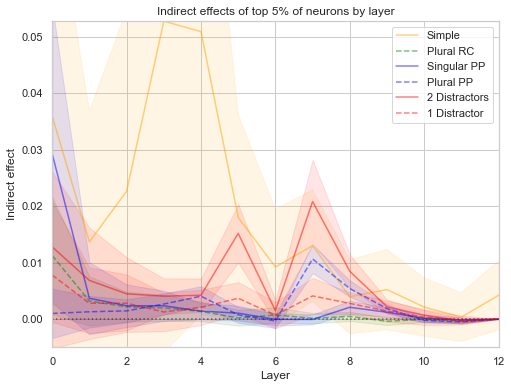

In [145]:
sns.set_style('whitegrid')
language = 'en'
#model = 'bert-base-german-cased'
#model = 'bert-base-dutch-cased'
#model = 'bert-base-finnish-cased-v1'
#model = 'camembert-base'
#model = 'bert-base-cased'
#model = 'bert-base-multilingual-cased'
model = 'xlm-roberta-base'

def graph_all_neuron(language):
    lines = get_lines(syn_structure, language, model) 
    plt.figure(figsize=(8,6))
    maximum = 0
    for f, color, label, linestyle in lines:
        # df = data_agg[f].loc[data_top5[f]].sort_values('layer').reset_index()
        df = data_agg[f].sort_values('layer').reset_index()
        effect_mean = df.groupby('layer').mean().effect_mean
        effect_std = df.groupby('layer').mean().effect_sem
        plt.plot(
            df.layer.unique(), 
            effect_mean,
            label=label, color=color, linestyle=linestyle, alpha=0.5,
        )
        plt.fill_between(
            df.layer.unique(),
            effect_mean + effect_std,
            effect_mean - effect_std,
            alpha=0.1, color=color
        )
        if float(max(effect_mean)) > maximum:
            maximum = float(max(effect_mean))
    plt.legend()
    plt.title('Indirect effects of top 5% of neurons by layer')
    plt.xlabel('Layer')
    plt.ylabel('Indirect effect')
    plt.ylim([-0.005, maximum])
    plt.hlines(0, 0, 24, color='black', alpha=0.5, linestyle='dotted')
    plt.xlim([0,12])
    plt.savefig(f'./figures/all_neurons_roberta_{language}1.png')
    plt.show()
graph_all_neuron(language)

In [81]:
import pickle
from collections import defaultdict

model_code_to_name = {
    'distilgpt2': 'DistilGPT-2',
    'gpt2': 'GPT-2 Small',
    'gpt2-medium': 'GPT-2 Medium',
    'xlnet-base-cased': 'XLNet',
    'transfo-xl-wt103': 'Transformer-XL',
    'gpt2-random': 'GPT-2 Small (Random)',
    'bert-base-multilingual-cased': 'Multilingual BERT'
}
# TODO change 
language = 'fi'
model = 'bert-base-german-cased' # de monolingual
#model = 'bert-base-dutch-cased' # nl monolingual
model = 'bert-base-finnish-cased-v1' # fi monolingual
#model = 'camembert-base' # fr monolingual
#model = 'bert-base-cased' # en monolingual
#model = 'bert-base-multilingual-cased' # multilingual bert
#model = 
lines = get_lines(syn_structure1, language, model)

num_layers = 0
neurons_by_layer = defaultdict(lambda: defaultdict(set))
neuron_sets = defaultdict(set)
structures = []
for f, color, structure, linestyle in lines:
    structures.append(structure)
    for row in data_top5[f]:
        layer_neuron = "{}-{}".format(row[0], row[1])
        num_layers = max(num_layers, row[0])
        neuron_sets[structure].update([layer_neuron])
        neurons_by_layer[structure][row[0]].update([layer_neuron])

'''
# uncomment for single figure for all layers
intersection_proportions = []
for structure1 in structures:
    intersection_proportions.append([])
    for structure2 in structures:
        overlap_count = len(neuron_sets[structure1].intersection(neuron_sets[structure2]))
        original_count = len(neuron_sets[structure1])
        intersection_proportions[-1].append((overlap_count / original_count) * 100)

# plot confusion matrix
plt.figure(figsize=(25, 20))
plt.matshow(intersection_proportions, cmap=plt.cm.gray_r, vmin=0, vmax=100)
cbar = plt.colorbar()
cbar.set_label('Top 5% neuron overlap')
plt.grid(False)
tick_marks = np.arange(len(intersection_proportions))
plt.xticks(tick_marks, structures, rotation=45, ha='left')
plt.yticks(tick_marks, structures)

# annotate matrix
for (i, j), z in np.ndenumerate(intersection_proportions):
    if z < 50:
        this_color = 'black'
    else:
        this_color = 'white'
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=6, color=this_color)

# plt.savefig(f'../neuron_overlap_{model}.pdf', bbox_inches='tight')
plt.show()
'''
sns.set(font_scale=1.3)

# load hypothesis matrix for comparison
# hypothesis_matrix = pickle.load(open('../hypothesis_matrix.pkl', 'rb'))
# np_hypothesis = np.array(hypothesis_matrix)
# x_idx = np.hstack(np_hypothesis[i][:i] for i in range(np_hypothesis.shape[0]))
# x_idx = scipy.stats.rankdata(np.array(hypothesis_matrix), method='min')

# layer-wise overlap proportions
'''
for layer in range(num_layers+1):
    intersection_proportions = defaultdict(list)
    for structure1 in structures:
        intersection_proportions[layer].append([])
        for structure2 in structures:
            if structure1 == structure2:
                continue
            overlap_count = len(neurons_by_layer[structure1][layer].intersection(neurons_by_layer[structure2][layer]))
            original_count = len(neurons_by_layer[structure1][layer])
            intersection_proportions[layer][-1].append((overlap_count / original_count) * 100)
            print(layer, structure1, structure2, intersection_proportions[layer][-1])
'''

# overall top neuron overlap proportions
for structure1 in structures:
    for structure2 in structures:
        if structure1 == structure2:
            continue
        shared_neurons = neuron_sets[structure1].intersection(neuron_sets[structure2])
        overlap_count = len(shared_neurons)
        original_count = len(neuron_sets[structure1])
        intersection_proportion = overlap_count / original_count
        #print(f"{structure1} / {structure2}: {intersection_proportion * 100}%")
        print(f"{structure1} / {structure2}: {intersection_proportion * 100}% ({shared_neurons})")

    '''
    # annotate matrix
    for (i, j), z in np.ndenumerate(intersection_proportions[layer]):
        if z < 50:
            this_color = 'black'
        else:
            this_color = 'white'
    '''

    '''
    # calculate and print correlation of hypothesis w/ layer neuron overlap
    np_intersection = np.array(intersection_proportions[layer])
    y_idx = np.hstack(np_intersection[i][:i] for i in range(np_intersection.shape[0]))
    # spearman_corr = scipy.stats.spearmanr(x_idx, y_idx)
    diff_norm = np.linalg.norm(np.subtract(x_idx, y_idx), ord=1)
    print("{} Layer {} correlation: {} (p=0)".format(
        model_code_to_name[model],
        layer,
        diff_norm))
    #    spearman_corr[1]
    #))
    '''
    
    '''
    if num_layers - layer < 5:
        # plot confusion matrix
        # if True:
        plt.figure(figsize=(12, 10))
        plt.matshow(intersection_proportions[layer], cmap=plt.cm.gray_r, vmin=0, vmax=100)
        cbar = plt.colorbar()
        cbar.set_label('Top 5% neuron overlap')
        plt.grid(False)
        tick_marks = np.arange(len(intersection_proportions[layer]))
        plt.xticks(tick_marks, structures, rotation=45, ha='left')
        plt.yticks(tick_marks, structures)
        plt.title(f"{model_code_to_name[model]} Layer {layer}")
        plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=6, color=this_color)
        # plt.savefig(f'../layer_neuron_overlap/neuron_overlap_{model}_layer_{layer}.pdf', format='pdf', bbox_inches='tight')
        # plt.show()
    '''

Simple / Sigular RC: 13.043478260869565% ({'7-120', '3-34', '5-34', '7-538', '6-34', '2-34', '9-34', '4-34', '1-34', '7-381', '8-34', '2-212'})
Simple / Plural RC: 1.0869565217391304% ({'8-34'})
Simple / Singular PP: 23.91304347826087% ({'8-749', '9-470', '7-620', '6-34', '2-34', '10-597', '4-34', '1-34', '5-34', '7-120', '7-34', '9-734', '9-34', '7-538', '7-381', '3-34', '9-679', '8-198', '8-34', '8-743', '8-386', '2-212'})
Simple / Plural PP: 20.652173913043477% ({'8-749', '9-470', '8-386', '6-34', '2-34', '4-34', '1-34', '9-749', '5-34', '7-120', '7-34', '9-734', '6-381', '9-34', '7-381', '3-34', '10-30', '9-679', '8-34'})
Sigular RC / Simple: 13.043478260869565% ({'7-120', '3-34', '5-34', '7-538', '6-34', '2-34', '9-34', '4-34', '1-34', '7-381', '8-34', '2-212'})
Sigular RC / Plural RC: 10.869565217391305% ({'1-690', '1-288', '0-453', '1-323', '2-266', '1-236', '2-323', '0-660', '3-546', '8-34'})
Sigular RC / Singular PP: 27.173913043478258% ({'5-516', '2-48', '6-516', '6-34', '2-3

In [52]:
# save top neurons in (layer, neuron) format in a .csv
file_list = [os.path.splitext(os.path.basename(_file))[0] for _file in data.items() if "indirect" in _file]
for _file in data.items():
    base_file_noext = os.path.splitext(os.path.basename(_file))[0]
    with open(f"top_neurons_01_{base_file_noext}.csv") as neurons_csv:
        for neuron in data_top5[_file]:
            neurons_csv.write(f"{layer},{neuron}\n")

MultiIndex([(12, 483),
            ( 4, 688),
            ( 8, 402),
            (12,  40),
            ( 0, 265)],
           names=['layer', 'neuron'])
{12: 9, 4: 4, 8: 13, 0: 8, 6: 4, 3: 4, 9: 13, 2: 4, 11: 11, 1: 4, 10: 9, 7: 6, 5: 3}


<Figure size 864x720 with 0 Axes>

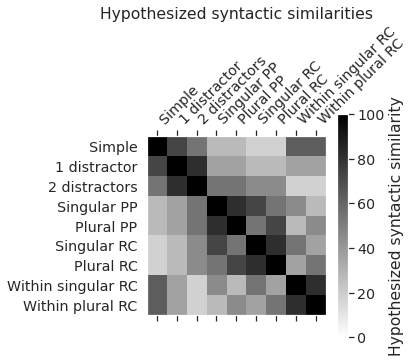

In [16]:
# produce hypothesis matrix
'''
features:
    - subject and verb separated
    - tokens between subject and verb
    - adverbial distractor(s)
    - has noun attractor
    - number of attractor
    - contains relative clause
    - contains prepositional phrase
'''

import pickle

structures = ['Simple', '1 distractor', '2 distractors', 'Singular PP', 'Plural PP',
              'Singular RC', 'Plural RC', 'Within singular RC', 'Within plural RC']

# one row per structure
# one column per feature
feature_matrix = [
        [0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0],
        [1, 3, 1, 0, 0, 0, 0],
        [1, 3, 0, 1, 1, 0, 1],
        [1, 3, 0, 1, 2, 0, 1],
        [1, 4, 0, 1, 1, 1, 0],
        [1, 4, 0, 1, 2, 1, 0],
        [0, 0, 0, 1, 1, 1, 0],
        [0, 0, 0, 1, 2, 1, 0]
        ]
'''
# modified matrix
feature_matrix = [
        [0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0],
        [1, 3, 1, 0, 0, 0, 0],
        [1, 3, 0, 1, 1, 0, 0],
        [1, 3, 0, 1, 2, 0, 0],
        [1, 4, 0, 1, 1, 0, 0],
        [1, 4, 0, 1, 2, 0, 0],
        [0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 1, 2, 0, 0]
        ]
'''
# max distance: 6.5
# calculate hypothesis matrix
h_matrix = []
for structure_1 in feature_matrix:
    h_matrix.append([])
    for structure_2 in feature_matrix:
        distance = 0
        for (feat_idx, (feat_1, feat_2)) in enumerate(zip(structure_1, structure_2)):
            if feat_idx == 1:   # calculate distance metric (divide diff by 2)
                distance += abs(feat_1 - feat_2) / 2
            elif feat_idx == 4: # calculate ordinal metric (0 if equal, 1 otherwise)
                ord_diff = 0 if feat_1 == feat_2 else 1
                distance += ord_diff
            else:
                distance += abs(feat_1 - feat_2) / 2
        similarity = 5.5 - distance
        similarity = (similarity / 5.5) * 100 
        h_matrix[-1].append(similarity)


# write hypothesis matrix to file
with open("../hypothesis_matrix.pkl", "wb") as out_mat:
    pickle.dump(h_matrix, out_mat)

# plot results
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.3)
plt.matshow(h_matrix, cmap=plt.cm.gray_r, vmin=0) #, vmax=6.5)
cbar = plt.colorbar()
cbar.set_label('Hypothesized syntactic similarity')
plt.grid(False)
tick_marks = np.arange(len(h_matrix))
plt.xticks(tick_marks, structures, rotation=45, ha='left')
plt.yticks(tick_marks, structures)
plt.title("Hypothesized syntactic similarities")
plt.savefig('../similarity_matrix_100.pdf', format='pdf', bbox_inches='tight')
plt.show()

GPT-2 Small (Random) Layer 0 correlation: 830.3827751196172 (p=0)
GPT-2 Small (Random) Layer 1 correlation: 839.2344497607655 (p=0)
GPT-2 Small (Random) Layer 2 correlation: 858.133971291866 (p=0)
GPT-2 Small (Random) Layer 3 correlation: 780.1435406698565 (p=0)
GPT-2 Small (Random) Layer 4 correlation: 811.9617224880383 (p=0)
GPT-2 Small (Random) Layer 5 correlation: 846.88995215311 (p=0)
GPT-2 Small (Random) Layer 6 correlation: 870.334928229665 (p=0)
GPT-2 Small (Random) Layer 7 correlation: 873.9234449760766 (p=0)
GPT-2 Small (Random) Layer 8 correlation: 828.7081339712919 (p=0)
[[100.0, 18.421052631578945, 15.789473684210526, 23.684210526315788, 28.947368421052634, 15.789473684210526, 18.421052631578945, 10.526315789473683, 13.157894736842104], [18.421052631578945, 100.0, 50.0, 50.0, 44.73684210526316, 47.368421052631575, 44.73684210526316, 5.263157894736842, 2.631578947368421], [15.789473684210526, 50.0, 100.0, 47.368421052631575, 47.368421052631575, 36.84210526315789, 36.8421052

<Figure size 864x720 with 0 Axes>

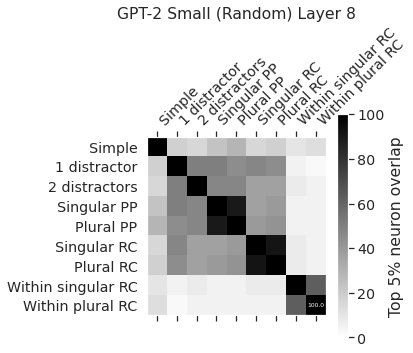

GPT-2 Small (Random) Layer 9 correlation: 817.4641148325359 (p=0)
[[100.0, 26.31578947368421, 28.947368421052634, 18.421052631578945, 18.421052631578945, 21.052631578947366, 23.684210526315788, 7.894736842105263, 5.263157894736842], [26.31578947368421, 100.0, 44.73684210526316, 47.368421052631575, 44.73684210526316, 36.84210526315789, 36.84210526315789, 7.894736842105263, 5.263157894736842], [28.947368421052634, 44.73684210526316, 100.0, 50.0, 47.368421052631575, 36.84210526315789, 39.473684210526315, 13.157894736842104, 10.526315789473683], [18.421052631578945, 47.368421052631575, 50.0, 100.0, 94.73684210526315, 36.84210526315789, 39.473684210526315, 5.263157894736842, 2.631578947368421], [18.421052631578945, 44.73684210526316, 47.368421052631575, 94.73684210526315, 100.0, 34.21052631578947, 36.84210526315789, 5.263157894736842, 2.631578947368421], [21.052631578947366, 36.84210526315789, 36.84210526315789, 36.84210526315789, 34.21052631578947, 100.0, 94.73684210526315, 5.2631578947368

<Figure size 864x720 with 0 Axes>

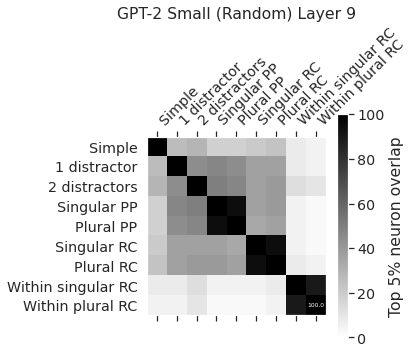

GPT-2 Small (Random) Layer 10 correlation: 815.5502392344496 (p=0)
[[100.0, 23.684210526315788, 21.052631578947366, 18.421052631578945, 21.052631578947366, 15.789473684210526, 18.421052631578945, 15.789473684210526, 15.789473684210526], [23.684210526315788, 100.0, 50.0, 44.73684210526316, 47.368421052631575, 23.684210526315788, 26.31578947368421, 5.263157894736842, 2.631578947368421], [21.052631578947366, 50.0, 100.0, 44.73684210526316, 50.0, 31.57894736842105, 34.21052631578947, 5.263157894736842, 2.631578947368421], [18.421052631578945, 44.73684210526316, 44.73684210526316, 100.0, 94.73684210526315, 26.31578947368421, 28.947368421052634, 7.894736842105263, 7.894736842105263], [21.052631578947366, 47.368421052631575, 50.0, 94.73684210526315, 100.0, 31.57894736842105, 34.21052631578947, 7.894736842105263, 7.894736842105263], [15.789473684210526, 23.684210526315788, 31.57894736842105, 26.31578947368421, 31.57894736842105, 100.0, 94.73684210526315, 7.894736842105263, 5.263157894736842], 

<Figure size 864x720 with 0 Axes>

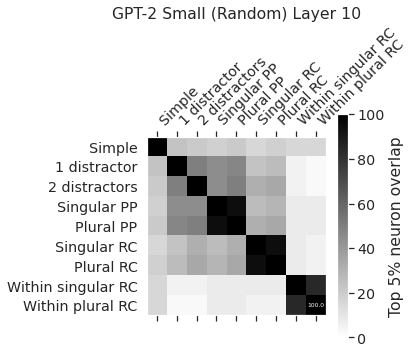

GPT-2 Small (Random) Layer 11 correlation: 903.8277511961724 (p=0)
[[100.0, 18.421052631578945, 10.526315789473683, 7.894736842105263, 10.526315789473683, 13.157894736842104, 13.157894736842104, 10.526315789473683, 15.789473684210526], [18.421052631578945, 100.0, 50.0, 50.0, 50.0, 36.84210526315789, 36.84210526315789, 5.263157894736842, 7.894736842105263], [10.526315789473683, 50.0, 100.0, 42.10526315789473, 42.10526315789473, 28.947368421052634, 28.947368421052634, 5.263157894736842, 7.894736842105263], [7.894736842105263, 50.0, 42.10526315789473, 100.0, 97.36842105263158, 36.84210526315789, 36.84210526315789, 7.894736842105263, 2.631578947368421], [10.526315789473683, 50.0, 42.10526315789473, 97.36842105263158, 100.0, 36.84210526315789, 36.84210526315789, 7.894736842105263, 2.631578947368421], [13.157894736842104, 36.84210526315789, 28.947368421052634, 36.84210526315789, 36.84210526315789, 100.0, 100.0, 2.631578947368421, 7.894736842105263], [13.157894736842104, 36.84210526315789, 28

<Figure size 864x720 with 0 Axes>

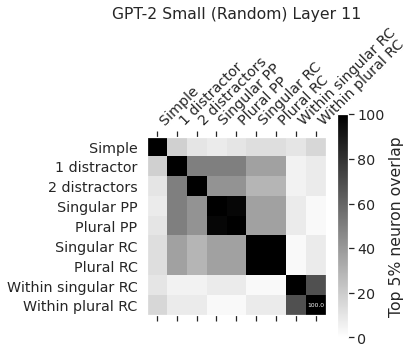

GPT-2 Small (Random) Layer 12 correlation: 1396.1722488038276 (p=0)
[[100.0, 2.631578947368421, 0.0, 2.631578947368421, 5.263157894736842, 10.526315789473683, 2.631578947368421, 26.31578947368421, 21.052631578947366], [2.631578947368421, 100.0, 21.052631578947366, 0.0, 18.421052631578945, 0.0, 0.0, 7.894736842105263, 5.263157894736842], [0.0, 21.052631578947366, 100.0, 5.263157894736842, 5.263157894736842, 5.263157894736842, 7.894736842105263, 7.894736842105263, 7.894736842105263], [2.631578947368421, 0.0, 5.263157894736842, 100.0, 5.263157894736842, 5.263157894736842, 5.263157894736842, 2.631578947368421, 2.631578947368421], [5.263157894736842, 18.421052631578945, 5.263157894736842, 5.263157894736842, 100.0, 7.894736842105263, 7.894736842105263, 2.631578947368421, 2.631578947368421], [10.526315789473683, 0.0, 5.263157894736842, 5.263157894736842, 7.894736842105263, 100.0, 10.526315789473683, 5.263157894736842, 5.263157894736842], [2.631578947368421, 0.0, 7.894736842105263, 5.263157894

<Figure size 864x720 with 0 Axes>

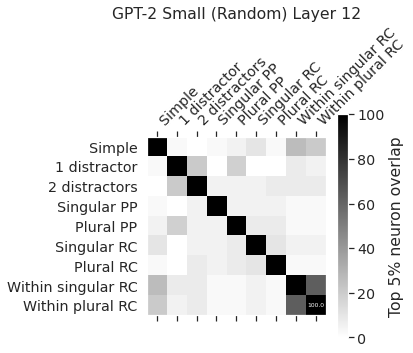

In [12]:
import pickle
from collections import defaultdict

model_code_to_name = {
    'distilgpt2': 'DistilGPT-2',
    'gpt2': 'GPT-2 Small',
    'gpt2-medium': 'GPT-2 Medium',
    'xlnet-base-cased': 'XLNet',
    'transfo-xl-wt103': 'Transformer-XL',
    'gpt2-random': 'GPT-2 Small (Random)'
}

model = 'gpt2-random'
lines = [
    (f'none_indirect_{model}.feather',         'orange',    'Simple', '-'),
    (f'distractor_1_indirect_{model}.feather', 'green', '1 distractor',  '--'),
    (f'distractor_indirect_{model}.feather',   'green', '2 distractors', '-'),
    (f'singular_indirect_{model}.feather',     'blue',  'Singular PP',   '-'),
    (f'plural_indirect_{model}.feather',       'blue',  'Plural PP',     '--'),
    ('_'.join(['rc_singular', 'indirect', f'{model}.feather']), 'purple', 'Singular RC', '-'),
    ('_'.join(['rc_plural',   'indirect', f'{model}.feather']), 'purple', 'Plural RC',   '--'),
    ('_'.join(['within_rc_singular', 'indirect', f'{model}.feather']), 'red', 'Within singular RC', '-'),
    ('_'.join(['within_rc_plural',   'indirect', f'{model}.feather']), 'red', 'Within plural RC',   '--'),
]

num_layers = 0
neurons_by_layer = defaultdict(lambda: defaultdict(set))
neuron_sets = defaultdict(set)
structures = []
for f, color, structure, linestyle in lines:
    structures.append(structure)
    for row in data_top5[f]:
        layer_neuron = "{}-{}".format(row[0], row[1])
        num_layers = max(num_layers, row[0])
        neuron_sets[structure].update([layer_neuron])
        neurons_by_layer[structure][row[0]].update([layer_neuron])

'''
# uncomment for single figure for all layers
intersection_proportions = []
for structure1 in structures:
    intersection_proportions.append([])
    for structure2 in structures:
        overlap_count = len(neuron_sets[structure1].intersection(neuron_sets[structure2]))
        original_count = len(neuron_sets[structure1])
        intersection_proportions[-1].append((overlap_count / original_count) * 100)

# plot confusion matrix
plt.figure(figsize=(25, 20))
plt.matshow(intersection_proportions, cmap=plt.cm.gray_r, vmin=0, vmax=100)
cbar = plt.colorbar()
cbar.set_label('Top 5% neuron overlap')
plt.grid(False)
tick_marks = np.arange(len(intersection_proportions))
plt.xticks(tick_marks, structures, rotation=45, ha='left')
plt.yticks(tick_marks, structures)

# annotate matrix
for (i, j), z in np.ndenumerate(intersection_proportions):
    if z < 50:
        this_color = 'black'
    else:
        this_color = 'white'
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=6, color=this_color)

# plt.savefig(f'../neuron_overlap_{model}.pdf', bbox_inches='tight')
plt.show()
'''
sns.set(font_scale=1.3)

# load hypothesis matrix for comparison
hypothesis_matrix = pickle.load(open('../hypothesis_matrix.pkl', 'rb'))
np_hypothesis = np.array(hypothesis_matrix)
x_idx = np.hstack(np_hypothesis[i][:i] for i in range(np_hypothesis.shape[0]))
# x_idx = scipy.stats.rankdata(np.array(hypothesis_matrix), method='min')

# uncomment for one figure per layer
for layer in range(num_layers+1):
    intersection_proportions = defaultdict(list)
    for structure1 in structures:
        intersection_proportions[layer].append([])
        for structure2 in structures:
            overlap_count = len(neurons_by_layer[structure1][layer].intersection(neurons_by_layer[structure2][layer]))
            original_count = len(neurons_by_layer[structure1][layer])
            intersection_proportions[layer][-1].append((overlap_count / original_count) * 100)
    
    '''
    # annotate matrix
    for (i, j), z in np.ndenumerate(intersection_proportions[layer]):
        if z < 50:
            this_color = 'black'
        else:
            this_color = 'white'
    '''

    # calculate and print correlation of hypothesis w/ layer neuron overlap
    np_intersection = np.array(intersection_proportions[layer])
    y_idx = np.hstack(np_intersection[i][:i] for i in range(np_intersection.shape[0]))
    # spearman_corr = scipy.stats.spearmanr(x_idx, y_idx)
    diff_norm = np.linalg.norm(np.subtract(x_idx, y_idx), ord=1)
    print("{} Layer {} correlation: {} (p=0)".format(
        model_code_to_name[model],
        layer,
        diff_norm))
    #    spearman_corr[1]
    #))
    
    if num_layers - layer < 5:
        # plot confusion matrix
        # if True:
        plt.figure(figsize=(12, 10))
        plt.matshow(intersection_proportions[layer], cmap=plt.cm.gray_r, vmin=0, vmax=100)
        cbar = plt.colorbar()
        cbar.set_label('Top 5% neuron overlap')
        plt.grid(False)
        tick_marks = np.arange(len(intersection_proportions[layer]))
        plt.xticks(tick_marks, structures, rotation=45, ha='left')
        plt.yticks(tick_marks, structures)
        plt.title(f"{model_code_to_name[model]} Layer {layer}")
        plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=6, color=this_color)
        plt.savefig(f'../layer_neuron_overlap/neuron_overlap_{model}_layer_{layer}.pdf', format='pdf', bbox_inches='tight')
        plt.show()

In [71]:
import pickle
from collections import defaultdict

model_code_to_name = {
    'distilgpt2': 'DistilGPT-2',
    'gpt2': 'GPT-2 Small',
    'gpt2-medium': 'GPT-2 Medium',
    'xlnet-base-cased': 'XLNet',
    'transfo-xl-wt103': 'Transformer-XL',
    'gpt2-random': 'GPT-2 Small (Random)',
    'bert-base-multilingual-cased': 'Multilingual BERT'
}
language = 'de'
model = 'bert-base-german-cased'
#model = 'bert-base-dutch-cased'
#model = 'bert-base-finnish-cased-v1'
#model = 'camembert-base'
#model = 'bert-base-cased'
#model = 'bert-base-multilingual-cased'
lines = get_lines(syn_structure1, language, model)

num_layers = 0
neurons_by_layer = defaultdict(lambda: defaultdict(set))
neuron_sets = defaultdict(set)
structures = []
for f, color, structure, linestyle in lines:
    structures.append(structure)
    for row in data_top5[f]:
        layer_neuron = "{}-{}".format(row[0], row[1])
        num_layers = max(num_layers, row[0])
        neuron_sets[structure].update([layer_neuron])
        neurons_by_layer[structure][row[0]].update([layer_neuron])

'''
# uncomment for single figure for all layers
intersection_proportions = []
for structure1 in structures:
    intersection_proportions.append([])
    for structure2 in structures:
        overlap_count = len(neuron_sets[structure1].intersection(neuron_sets[structure2]))
        original_count = len(neuron_sets[structure1])
        intersection_proportions[-1].append((overlap_count / original_count) * 100)

# plot confusion matrix
plt.figure(figsize=(25, 20))
plt.matshow(intersection_proportions, cmap=plt.cm.gray_r, vmin=0, vmax=100)
cbar = plt.colorbar()
cbar.set_label('Top 5% neuron overlap')
plt.grid(False)
tick_marks = np.arange(len(intersection_proportions))
plt.xticks(tick_marks, structures, rotation=45, ha='left')
plt.yticks(tick_marks, structures)

# annotate matrix
for (i, j), z in np.ndenumerate(intersection_proportions):
    if z < 50:
        this_color = 'black'
    else:
        this_color = 'white'
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=6, color=this_color)

# plt.savefig(f'../neuron_overlap_{model}.pdf', bbox_inches='tight')
plt.show()
'''
sns.set(font_scale=1.3)

# load hypothesis matrix for comparison
# hypothesis_matrix = pickle.load(open('../hypothesis_matrix.pkl', 'rb'))
# np_hypothesis = np.array(hypothesis_matrix)
# x_idx = np.hstack(np_hypothesis[i][:i] for i in range(np_hypothesis.shape[0]))
# x_idx = scipy.stats.rankdata(np.array(hypothesis_matrix), method='min')

# layer-wise overlap proportions
'''
for layer in range(num_layers+1):
    intersection_proportions = defaultdict(list)
    for structure1 in structures:
        intersection_proportions[layer].append([])
        for structure2 in structures:
            if structure1 == structure2:
                continue
            overlap_count = len(neurons_by_layer[structure1][layer].intersection(neurons_by_layer[structure2][layer]))
            original_count = len(neurons_by_layer[structure1][layer])
            intersection_proportions[layer][-1].append((overlap_count / original_count) * 100)
            print(layer, structure1, structure2, intersection_proportions[layer][-1])
'''

# overall top neuron overlap proportions
for structure1 in structures:
    for structure2 in structures:
        if structure1 == structure2:
            continue
        shared_neurons = neuron_sets[structure1].intersection(neuron_sets[structure2])
        overlap_count = len(shared_neurons)
        original_count = len(neuron_sets[structure1])
        intersection_proportion = overlap_count / original_count
        #print(f"{structure1} / {structure2}: {intersection_proportion * 100}%")
        print(f"{structure1} / {structure2}: {intersection_proportion * 100}% ({shared_neurons})")

    '''
    # annotate matrix
    for (i, j), z in np.ndenumerate(intersection_proportions[layer]):
        if z < 50:
            this_color = 'black'
        else:
            this_color = 'white'
    '''

    '''
    # calculate and print correlation of hypothesis w/ layer neuron overlap
    np_intersection = np.array(intersection_proportions[layer])
    y_idx = np.hstack(np_intersection[i][:i] for i in range(np_intersection.shape[0]))
    # spearman_corr = scipy.stats.spearmanr(x_idx, y_idx)
    diff_norm = np.linalg.norm(np.subtract(x_idx, y_idx), ord=1)
    print("{} Layer {} correlation: {} (p=0)".format(
        model_code_to_name[model],
        layer,
        diff_norm))
    #    spearman_corr[1]
    #))
    '''
    
    '''
    if num_layers - layer < 5:
        # plot confusion matrix
        # if True:
        plt.figure(figsize=(12, 10))
        plt.matshow(intersection_proportions[layer], cmap=plt.cm.gray_r, vmin=0, vmax=100)
        cbar = plt.colorbar()
        cbar.set_label('Top 5% neuron overlap')
        plt.grid(False)
        tick_marks = np.arange(len(intersection_proportions[layer]))
        plt.xticks(tick_marks, structures, rotation=45, ha='left')
        plt.yticks(tick_marks, structures)
        plt.title(f"{model_code_to_name[model]} Layer {layer}")
        plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=6, color=this_color)
        # plt.savefig(f'../layer_neuron_overlap/neuron_overlap_{model}_layer_{layer}.pdf', format='pdf', bbox_inches='tight')
        # plt.show()
    '''

Simple / Sigular RC: 6.521739130434782% ({'9-423', '7-635', '11-485', '6-635', '8-423', '7-423'})
Simple / Plural RC: 3.260869565217391% ({'7-635', '6-635', '7-751'})
Simple / Singular PP: 10.869565217391305% ({'5-615', '8-635', '7-635', '9-635', '4-685', '9-320', '6-635', '2-546', '10-635', '11-635'})
Simple / Plural PP: 6.521739130434782% ({'8-635', '7-635', '9-635', '6-635', '2-546', '10-635'})
Sigular RC / Simple: 6.521739130434782% ({'9-423', '7-635', '11-485', '6-635', '8-423', '7-423'})
Sigular RC / Plural RC: 28.26086956521739% ({'7-635', '11-205', '10-158', '1-158', '5-405', '6-158', '8-488', '8-158', '10-205', '2-224', '7-210', '4-285', '11-137', '5-592', '6-298', '6-592', '6-405', '5-471', '4-471', '7-158', '4-405', '6-635', '4-592', '3-224', '5-285', '9-608'})
Sigular RC / Singular PP: 18.478260869565215% ({'4-224', '7-635', '5-635', '6-405', '4-405', '7-379', '6-635', '4-12', '5-568', '5-714', '5-405', '4-635', '6-714', '7-158', '5-285', '7-488', '4-285'})
Sigular RC / Plu

In [6]:
data_agg[f]

effect_mean  effect_std  effect_sem  \
layer neuron                                        
0     0         -0.000173    0.001704    0.000121   
      1          0.000122    0.002817    0.000199   
      2          0.000187    0.001270    0.000090   
      3          0.000686    0.001806    0.000128   
      4         -0.000082    0.003413    0.000241   
...                   ...         ...         ...   
48    1595      -0.000101    0.001203    0.000085   
      1596      -0.000180    0.002188    0.000155   
      1597       0.003047    0.005648    0.000399   
      1598      -0.001251    0.002823    0.000200   
      1599      -0.000179    0.001395    0.000099   

              singular_grammaticality_mean  singular_grammaticality_std  \
layer neuron                                                              
0     0                           0.136953                     0.300352   
      1                           0.136953                     0.300352   
      2                           0.136953                     0.300352   
      3                           0.136953                     0.300352   
      4                           0.136953                     0.300352   
...                                    ...                          ...   
48    1595                        0.136953                     0.300352   
      1596                        0.136953                     0.300352   
      1597                        0.136953                     0.300352   
      1598                        0.136953                     0.300352   
      1599                        0.136953                     0.300352   

              singular_grammaticality_sem  plural_grammaticality_mean  \
layer neuron                                                            
0     0                          0.021238                    0.010118   
      1                          0.021238                    0.010118   
      2                          0.021238                    0.010118   
      3                          0.021238                    0.010118   
      4                          0.021238                    0.010118   
...                                   ...                         ...   
48    1595                       0.021238                    0.010118   
      1596                       0.021238                    0.010118   
      1597                       0.021238                    0.010118   
      1598                       0.021238                    0.010118   
      1599                       0.021238                    0.010118   

              plural_grammaticality_std  plural_grammaticality_sem  \
layer neuron                                                         
0     0                        0.012618                   0.000892   
      1                        0.012618                   0.000892   
      2                        0.012618                   0.000892   
      3                        0.012618                   0.000892   
      4                        0.012618                   0.000892   
...                                 ...                        ...   
48    1595                     0.012618                   0.000892   
      1596                     0.012618                   0.000892   
      1597                     0.012618                   0.000892   
      1598                     0.012618                   0.000892   
      1599                     0.012618                   0.000892   

              inv_singular_grammaticality_mean  \
layer neuron                                     
0     0                              27.819726   
      1                              27.819726   
      2                              27.819726   
      3                              27.819726   
      4                              27.819726   
...                                        ...   
48    1595                           27.819726   
      1596                           

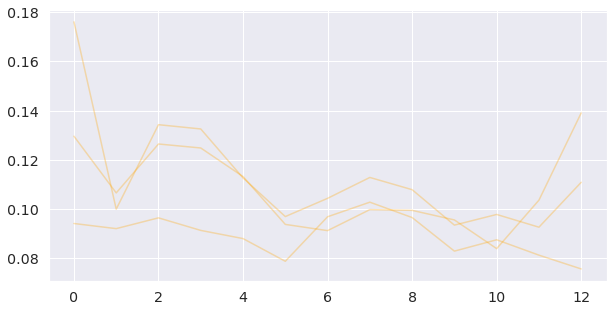

In [9]:
plt.figure(figsize=(10,5))
for f in filter(lambda x: 'indirect' in x, data_agg):
    if 'distil' in f:
        color = 'red'
    elif 'medium' in f:
        color = 'green'
    elif 'large' in f:
        color = 'blue'
    elif 'gpt2-xl' in f:
        color = 'purple'
    elif 'xlnet' in f:
        color = 'black'
    else:
        color = 'orange'
    df = data_agg[f]
    idx = data_top5[f]
    effects = (
        df.loc[idx]
        .sort_values('layer')
        .reset_index()
        .groupby('layer')
        .mean().effect_mean
    )
    plt.plot(
        effects,
        label=f[:-8].replace('_',' '), alpha=0.3, color=color,
    )
# plt.legend()
plt.show()

In [6]:
sns.set(font_scale=1.45)
sns.set_style('whitegrid')

model = "bert-base-cased"
lines = [
    (f'none_indirect_{model}.feather',         'orange',    'Simple (en)', '-'),
    (f'none_fr_indirect_camembert-base.feather', 'orange', 'Simple (fr)', '--'),
    (f'none_nl_indirect_bert-base-dutch-cased.feather', 'orange', 'Simple (nl)', '-.'),
    (f'none_fi_indirect_bert-base-finnish-cased-v1.feather', 'orange', 'Simple (fi)', '-*'),
    (f'rc_singular_indirect_{model}.feather', 'green', 'Singular RC (en)', '-'),
    (f'rc_singular_fr_indirect_camembert-base.feather', 'green', 'Singular RC (fr)', '--'),
    (f'rc_singular_nl_indirect_bert-base-dutch-cased.feather', 'green', 'Singular RC (nl)', '-.'),
    (f'rc_singular_fi_indirect_bert-base-finnish-cased-v1.feather', 'green', 'Singular RC (fi)', '-*')
]
    
plt.figure(figsize=(8,6))
for f, color, label, linestyle in lines:
    df = data_agg[f].loc[data_top5[f]].sort_values('layer').reset_index()
    # df = data_agg[f].sort_values('layer').reset_index()
    effect_mean = df.groupby('layer').mean().effect_mean
    effect_std = df.groupby('layer').mean().effect_sem
    if linestyle == '--':
        dashes = (7, 8)
        plt.plot(
            df.layer.unique(), 
            effect_mean,
            label=label, color=color, linestyle=linestyle, alpha=0.5,
            dashes=dashes
        )
    else:
        plt.plot(
            df.layer.unique(), 
            effect_mean,
            label=label, color=color, linestyle=linestyle, alpha=0.5,
        )
    plt.fill_between(
        df.layer.unique(),
        effect_mean + effect_std,
        effect_mean - effect_std,
        alpha=0.1, color=color
    )
plt.legend(bbox_to_anchor=(0.99,1.025), loc="upper left")
# plt.title('Indirect effects of top 5% of neurons by layer')
plt.xlabel('Layer')
plt.ylabel('Indirect effect')
# plt.title('XLNet')
# plt.ylim([-0.0005, 0.016])
plt.hlines(0, 0, 24, color='black', alpha=0.5, linestyle='dotted')
plt.xlim([0,12])
plt.savefig('../xlnet_outside.pdf', format='pdf', bbox_inches='tight')
plt.show()

TypeError: 'tuple' object is not callable

In [18]:
data_agg.keys()

dict_keys(['none_fi_indirect_bert-base-finnish-cased-v1_controlled.feather', 'none_nl_indirect_bert-base-dutch-cased_controlled.feather', 'rc_singular_de_indirect_bert-base-german-cased_controlled.feather', 'prep_singular_fr_indirect_camembert-base_controlled.feather', 'rc_singular_nl_indirect_bert-base-dutch-cased_controlled.feather', 'none_de_indirect_bert-base-german-cased_controlled.feather', 'rc_singular_fi_indirect_bert-base-finnish-cased-v1_controlled.feather', 'distractor_en_indirect_bert-base-cased_controlled.feather', 'none_en_indirect_bert-base-cased_controlled.feather', 'prep_plural_nl_indirect_bert-base-dutch-cased_controlled.feather', 'rc_singular_fr_indirect_camembert-base_controlled.feather', 'distractor_1_en_indirect_bert-base-cased_controlled.feather', 'prep_plural_en_indirect_bert-base-cased_controlled.feather', 'prep_plural_de_indirect_bert-base-german-cased_controlled.feather', 'rc_plural_en_indirect_bert-base-cased_controlled.feather', 'rc_plural_fr_indirect_camem

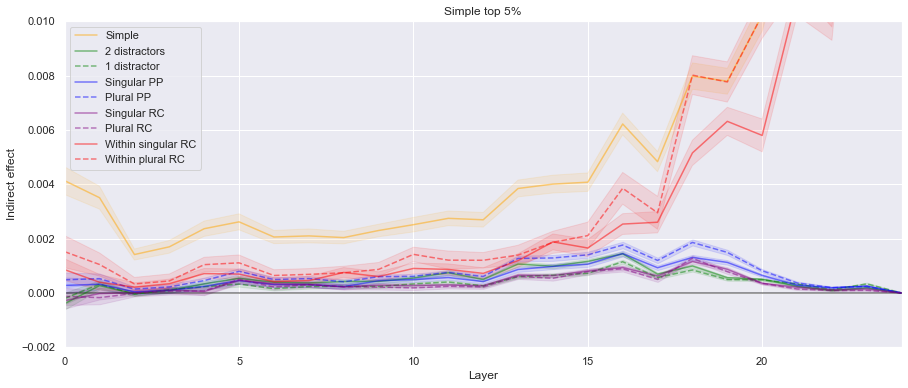

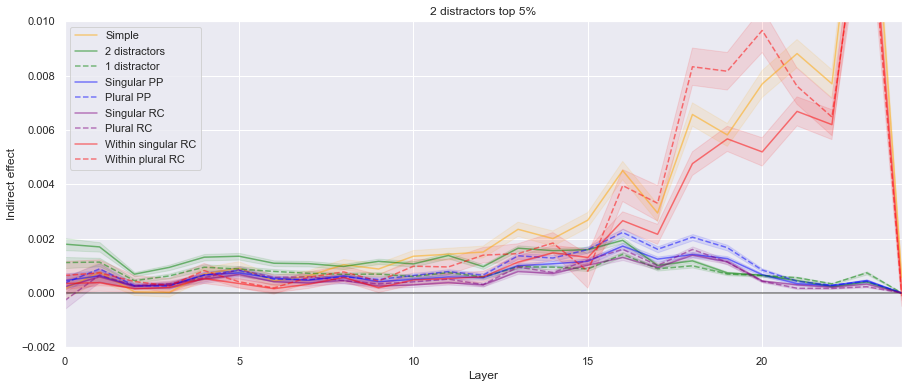

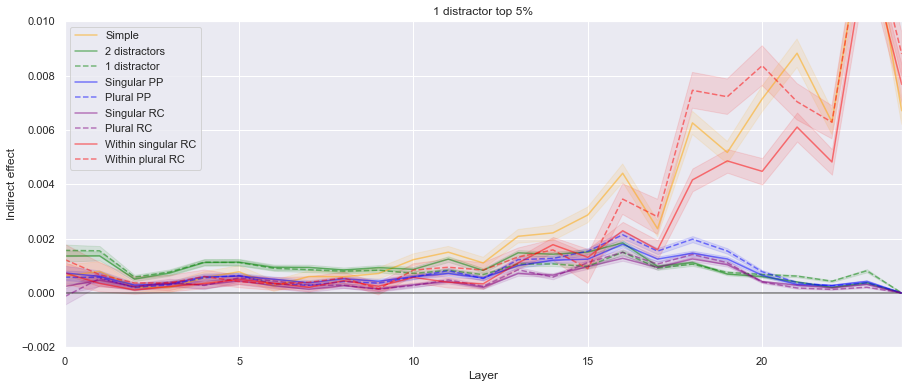

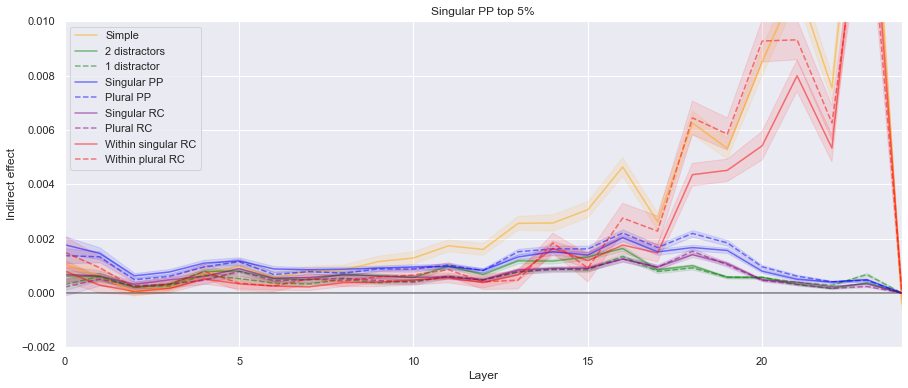

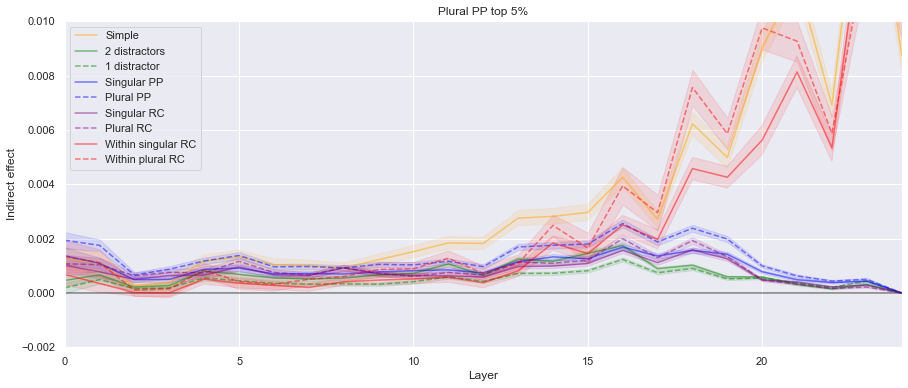

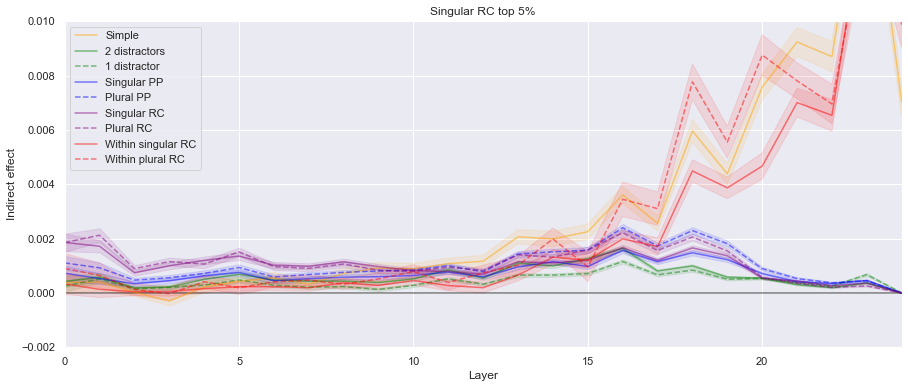

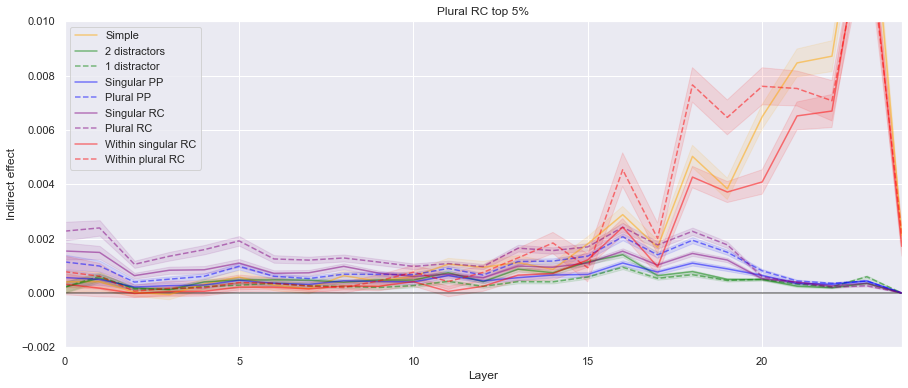

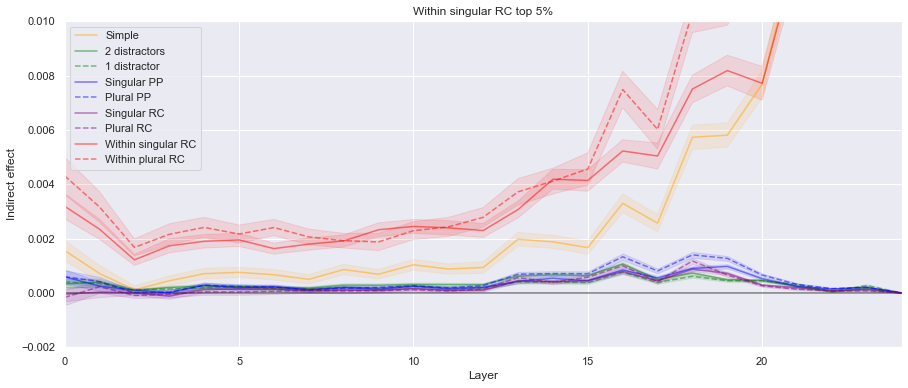

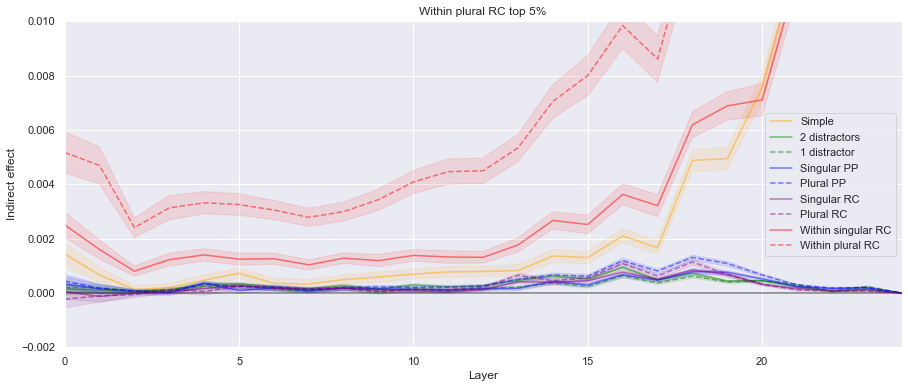

In [9]:
for g, _, title, _ in lines:
    plt.figure(figsize=(15,6))
    for f, color, label, linestyle in lines:
        df = data_agg[f].loc[data_top5[g]].sort_values('layer').reset_index()
        effect_mean = df.groupby('layer').mean().effect_mean
        effect_std = df.groupby('layer').mean().effect_sem
        plt.plot(
            df.layer.unique(), 
            effect_mean,
            label=label, color=color, linestyle=linestyle, alpha=0.5,
        )
        plt.fill_between(
            df.layer.unique(),
            effect_mean + effect_std,
            effect_mean - effect_std,
            alpha=0.1, color=color
        )
    plt.title(title + ' top 5%')
    plt.legend()
    plt.hlines(0, 0, 24, color='black', alpha=0.5)
    plt.xlim([0,24])
    plt.xlabel('Layer')
    plt.ylabel('Indirect effect')
    plt.ylim([-0.002, 0.01])
    plt.savefig('../top5.png')
    plt.show()

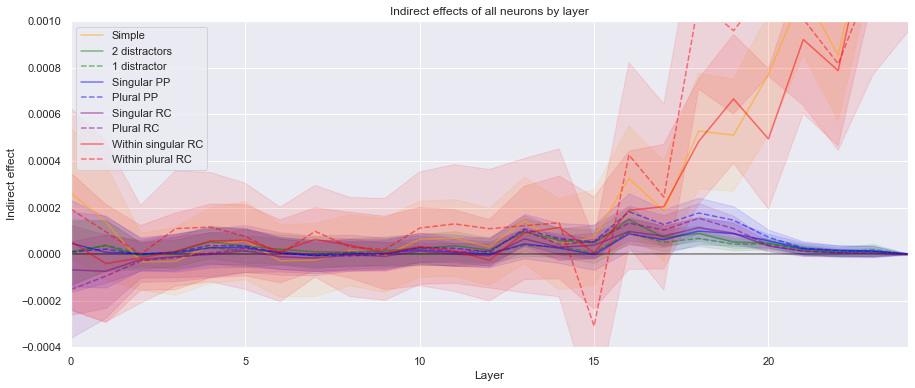

In [ ]:
plt.figure(figsize=(15,6))
for f, color, label, linestyle in lines:
    df = data_agg[f].sort_values('layer').reset_index()
    effect_mean = df.groupby('layer').mean().effect_mean
    effect_std = df.groupby('layer').mean().effect_sem
    plt.plot(
        df.layer.unique(), 
        effect_mean,
        label=label, color=color, linestyle=linestyle, alpha=0.5,
    )
    plt.fill_between(
        df.layer.unique(),
        effect_mean + effect_std,
        effect_mean - effect_std,
        alpha=0.1, color=color
    )
plt.legend()
plt.title('Indirect effects of all neurons by layer')
plt.xlabel('Layer')
plt.ylabel('Indirect effect')
plt.ylim([-0.0004, 0.001])
plt.hlines(0, 0, 24, color='black', alpha=0.5)
plt.xlim([0,24])
plt.savefig('../top5.png')
plt.show()

In [ ]:
data_agg[f].iloc[200]

effect_mean                            0.002704
effect_std                             0.005717
effect_sem                             0.000404
singular_grammaticality_mean           0.274619
singular_grammaticality_std            0.335955
singular_grammaticality_sem            0.023756
plural_grammaticality_mean             0.007932
plural_grammaticality_std              0.009146
plural_grammaticality_sem              0.000647
inv_singular_grammaticality_mean      13.498625
inv_singular_grammaticality_std       19.987312
inv_singular_grammaticality_sem        1.413316
inv_plural_grammaticality_mean       327.674767
inv_plural_grammaticality_std        395.512022
inv_plural_grammaticality_sem         27.966923
total_effect_mean                   3049.525111
total_effect_std                    6072.701853
total_effect_sem                     429.404866
Name: (0, 200), dtype: float64

100%|██████████| 4/4 [00:00<00:00, 977.69it/s]


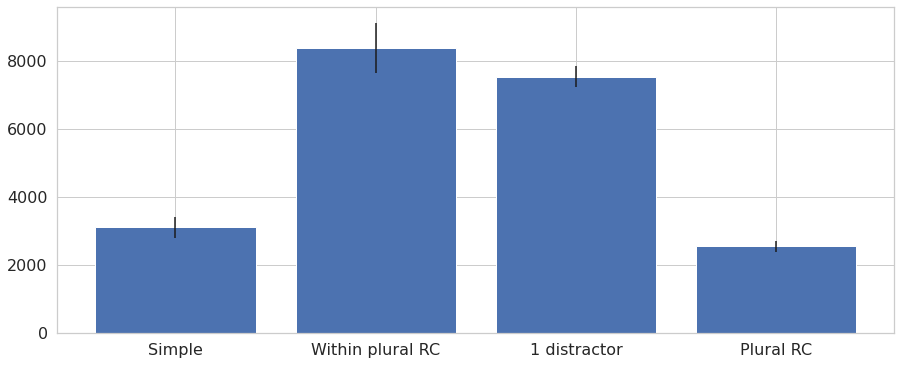

In [11]:
plt.figure(figsize=(15,6))
labels = []
bars   = []
errors = []
for f, color, label, linestyle in tqdm(lines):
    labels.append(label)
    bars.append  (data_agg[f].iloc[0].total_effect_mean)
    errors.append(data_agg[f].iloc[0].total_effect_sem)
plt.bar(labels, bars, yerr=errors)
plt.show()

In [24]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,6))
lines = [
    ('none_indirect_gpt2-medium.feather',         'orange',    'Simple', '-'),
    ('distractor_1_indirect_gpt2-medium.feather', 'red', '1 distractor',  '--'),
    ('distractor_indirect_gpt2-medium.feather', 'blue', '2 distractors', '-'),
    ('singular_indirect_gpt2-medium.feather', 'black', 'Singular PP', '-'),
    ('plural_indirect_gpt2-medium.feather', 'red', 'Plural PP', '-'),
    ('_'.join(['rc_singular',   'indirect', 'gpt2-medium.feather']), 'blue', 'Singular RC',   '--'),
    ('_'.join(['rc_plural',   'indirect', 'gpt2-medium.feather']), 'blue', 'Plural RC',   '--'),
    ('_'.join(['within_rc_singular',   'indirect', 'gpt2-medium.feather']), 'purple', 'Within singular RC',   '--'),
    ('_'.join(['within_rc_plural',   'indirect', 'gpt2-medium.feather']), 'purple', 'Within plural RC',   '--'),
]

labels = []
dfs = []
for f, color, label, linestyle in tqdm(lines):
    labels.append(label)
    df = data_agg[f]
    df['label'] = label
    dfs.append(df)

100%|██████████| 9/9 [00:00<00:00, 683.48it/s]


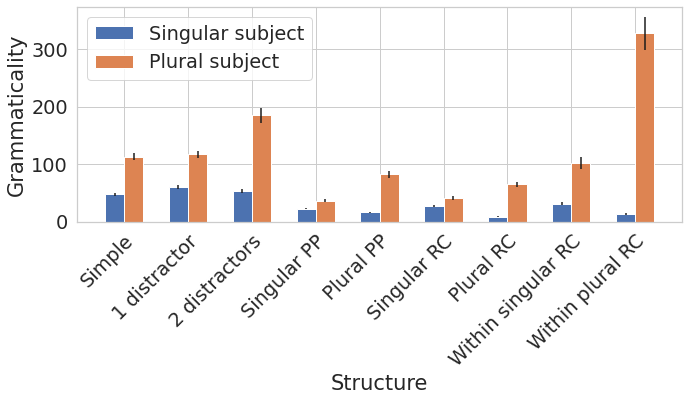

In [55]:
import matplotlib

matplotlib.rcParams['xtick.minor.visible'] = True
sns.set(font_scale=1.75)
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
df = (
    pd.concat(dfs)
    .sort_index()
    .loc[0,0]
    .set_index('label')
    [[
        'inv_singular_grammaticality_mean','inv_plural_grammaticality_mean',
        'inv_singular_grammaticality_sem','inv_plural_grammaticality_sem'
    ]]
)
x = np.arange(len(labels))
width = 0.3
# print(list(df['inv_singular_grammaticality_mean']))
plt.bar(x - width/2, list(df['inv_singular_grammaticality_mean']), width=width, yerr=list(df['inv_singular_grammaticality_sem']))
plt.bar(x + width/2, list(df['inv_plural_grammaticality_mean']), width=width, yerr=list(df['inv_plural_grammaticality_sem']))
plt.xticks(x, labels, rotation=45, ha='right', rotation_mode='anchor')
ax.xaxis.set_major_locator(matplotlib.ticker.LinearLocator())
plt.legend(['Singular subject', 'Plural subject'], loc='upper left')
plt.xlabel('Structure')
plt.ylabel('Grammaticality')
plt.tight_layout()
# plt.title('Grammaticality by example type')
plt.savefig('../grammaticality_small.pdf', format='pdf', bbox_inches='tight')
plt.show()

- [x] Within rc
- [ ] Show size dim for TE and NIE and Grammaticality
    - [x] NIE
- [ ] Universally top neurons
- [ ] Heatmaps w/ normalized colors?

In [18]:
lines = [
    ('none_indirect_gpt2.feather',         'orange',    'Simple', '-'),
    ('distractor_1_indirect_gpt2.feather', 'red', '1 distractor',  '-'),
    ('distractor_indirect_gpt2.feather', 'blue', '2 distractors', '-')
]

df1 = data[lines[0][0]]
df2 = data[lines[1][0]]

df1['name'] = lines[0][0]
df2['name'] = lines[1][0]

to_plot = (
    pd.concat([df1, df2])
    .melt(
        id_vars=('candidate1','base_string','name'), 
        value_vars=(
            'candidate1_base_prob', 'candidate2_base_prob', 'candidate1_alt1_prob', 'candidate2_alt1_prob'
        ),
        var_name='prob_type',
        value_name='prob'
    )
)

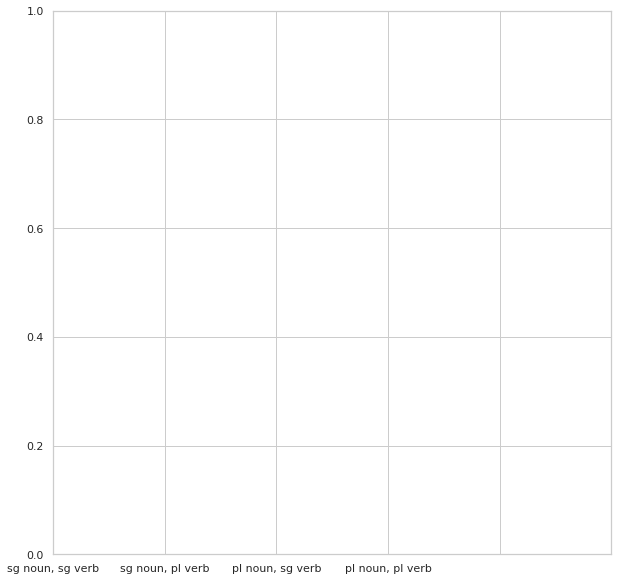

In [21]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10,10))
g = sns.boxplot(x='prob_type', y='prob', data=to_plot, hue='name', ax=ax)
ax.set_xticklabels((
    'sg noun, sg verb',
    'sg noun, pl verb',
    'pl noun, sg verb',
    'pl noun, pl verb'
))
# title
new_title = 'Example'
g.get_legend().set_title(new_title)
# replace labels
new_labels = ['Simple', '1 distractor', '2 distractors']
for t, l in zip(g.get_legend().texts, new_labels): t.set_text(l)
ax.set_xlabel = None
ax.set_ylabel = 'Probability'

In [45]:
data['none_indirect_gpt2-medium.feather']

,word,base_string,alt_string1,candidate1,candidate2,candidate1_base_prob,candidate2_base_prob,candidate1_alt1_prob,candidate2_alt1_prob,candidate1_prob,...,layer,neuron,singular_grammaticality,plural_grammaticality,inv_singular_grammaticality,inv_plural_grammaticality,yz,effect,total_effect,name
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,The {}_athlete_approves,The athlete,The athletes,['Ġapproves'],['Ġapprove'],0.000005,2.050610e-07,2.611536e-08,0.000003,0.000005,...,0,0,0.040475,0.007969,24.706765,125.493325,0.040467,-0.000198,3099.534150,none_indirect_gpt2-medium.feather
1,The {}_athlete_approves,The athlete,The athletes,['Ġapproves'],['Ġapprove'],0.000005,2.050610e-07,2.611536e-08,0.000003,0.000005,...,0,1,0.040475,0.007969,24.706765,125.493325,0.040701,0.005585,3099.534150,none_indirect_gpt2-medium.feather
2,The {}_athlete_approves,The athlete,The athletes,['Ġapproves'],['Ġapprove'],0.000005,2.050610e-07,2.611536e-08,0.000003,0.000005,...,0,2,0.040475,0.007969,24.706765,125.493325,0.040896,0.010399,3099.534150,none_indirect_gpt2-medium.feather
3,The {}_athlete_approves,The athlete,The athletes,['Ġapproves'],['Ġapprove'],0.000005,2.050610e-07,2.611536e-08,0.000003,0.000005,...,0,3,0.040475,0.007969,24.706765,125.493325,0.040577,0.002521,3099.534150,none_indirect_gpt2-medium.feather
4,The {}_athlete_approves,The athlete,The athletes,['Ġapproves'],['Ġapprove'],0.000005,2.050610e-07,2.611536e-08,0.000003,0.000005,...,0,4,0.040475,0.007969,24.706765,125.493325,0.040294,-0.004461,3099.534150,none_indirect_gpt2-medium.feather
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4787195,The {}_woman_observes,The woman,The women,['Ġobserves'],['Ġobserve'],0.000021,2.601502e-07,3.010518e-07,0.000014,0.000021,...,24,1019,0.012406,0.020804,80.604687,48.068143,0.012408,0.000145,3873.517608,none_indirect_gpt2-medium.feather
4787196,The {}_woman_observes,The woman,The women,['Ġobserves'],['Ġobserve'],0.000021,2.601502e-07,3.010518e-07,0.000014,0.000021,...,24,1020,0.012406,0.020804,80.604687,48.068143,0.012450,0.003508,3873.517608,none_indirect_gpt2-medium.feather
4787197,The {}_woman_observes,The woman,The women,['Ġobserves'],['Ġobserve'],0.000021,2.601502e-07,3.010518e-07,0.000014,0.000021,...,24,1021,0.012406,0.020804,80.604687,48.068143,0.012404,-0.000198,3873.517608,none_indirect_gpt2-medium.feather
